### Import libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import os
import kagglehub
import sys
import os
sys.path.append(os.path.abspath('..'))
from utils import helper_functions as hf
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andriizhurba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andriizhurba/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Load the data

In [5]:
path = kagglehub.dataset_download("kazanova/sentiment140")
path = os.path.join(path, "training.1600000.processed.noemoticon.csv")
dataset = pd.read_csv(path, encoding="latin", header=None)
dataset.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataset.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
dataset.shape

(1600000, 6)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user_id    1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
dataset.replace({"sentiment": {0: "negative", 4: "positive"}}, inplace=True)

**Distribution of the target variable**

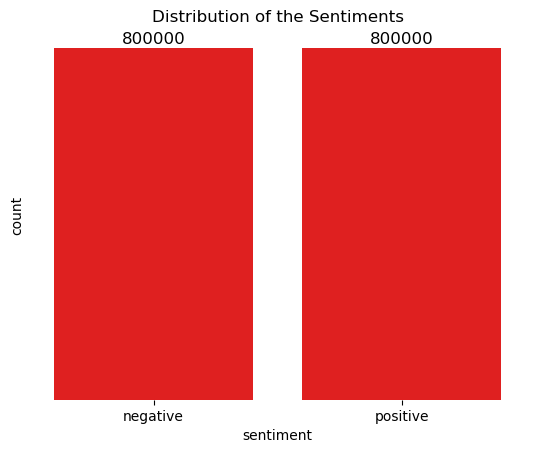

In [9]:
sns.countplot(x='sentiment', data=dataset, color="red")
hf.customize_bar(position="v", axes=plt.gca())
plt.title("Distribution of the Sentiments");

The above bar plot indicates that we have perfectly balanced classes. Each class has 800,000 of tweets.

### Train-test split

We will dedicate 5% of the dataset for test data, which will result in 80,000 of tweets.

In [10]:
train_data, test_data = train_test_split(dataset, test_size=0.05, 
                                         random_state=42,
                                         stratify=dataset['sentiment'])
train_data.shape

(1520000, 6)

## Exploratory Data Analysis

For our EDA, we will:
* preprocess the text:
    * get rid of URLs
    * get rid of usernames
    * get rid of non-alphanumeric characters
    * convert all characters to lower case
    * remove stop words
    * lemmatize words
* create newe features:
    * number of words
    * ratio of numbers
    * ratio of exclamation marks
    * average word length
    * text length
    * hashtag indicator
    * URL indicator
    * special characters indicator

In [11]:
for dataset in [train_data, test_data]:
    dataset["tokens"] = dataset["text"].apply(hf.preprocess_text)
    dataset["preprocessed_text"] = dataset["tokens"].apply(lambda tokens: " ".join(tokens))
    dataset["words_count"] = dataset["tokens"].apply(len)
    dataset["numbers_ratio"] = dataset["text"].apply(hf.numbers_ratio)
    dataset["hashtags"] = dataset["text"].apply(lambda x: re.findall(r'#\w+', x))
    dataset["exclamations_ratio"] = dataset["text"].apply(hf.exclamations_ratio)
    dataset["consecutive_exclmations"] = dataset["text"].apply(hf.consecutive_exclamations)
    dataset['text_length'] = dataset['text'].apply(len)
    dataset['avg_word'] = dataset['text'].apply(lambda x: hf.avg_word(x))
    dataset['has_special_characters'] = dataset['text'].apply(hf.contains_special_characters)
    dataset['has_url'] = dataset['text'].apply(hf.contains_url)
    dataset['has_hashtag'] = dataset['text'].apply(hf.contains_hashtag)

**Now, let's check the length of our tweets**

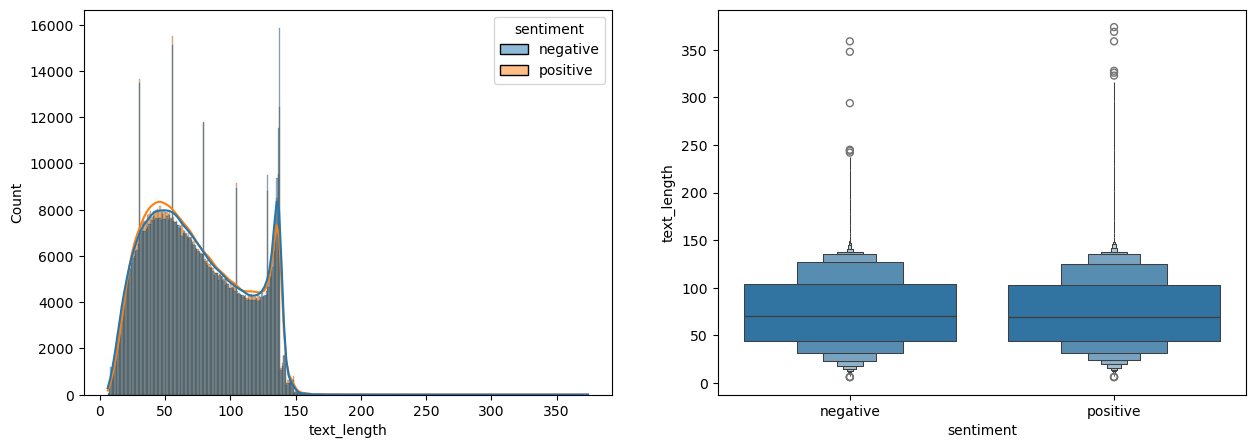

In [12]:
hf.box_hist_comparison(column="text_length", target="sentiment", data=train_data)

The above plots show us that the majority of tweets are shorter than 200 characters. However, there are some outliers which may contain up to 350-360 characters.

**Average words length**

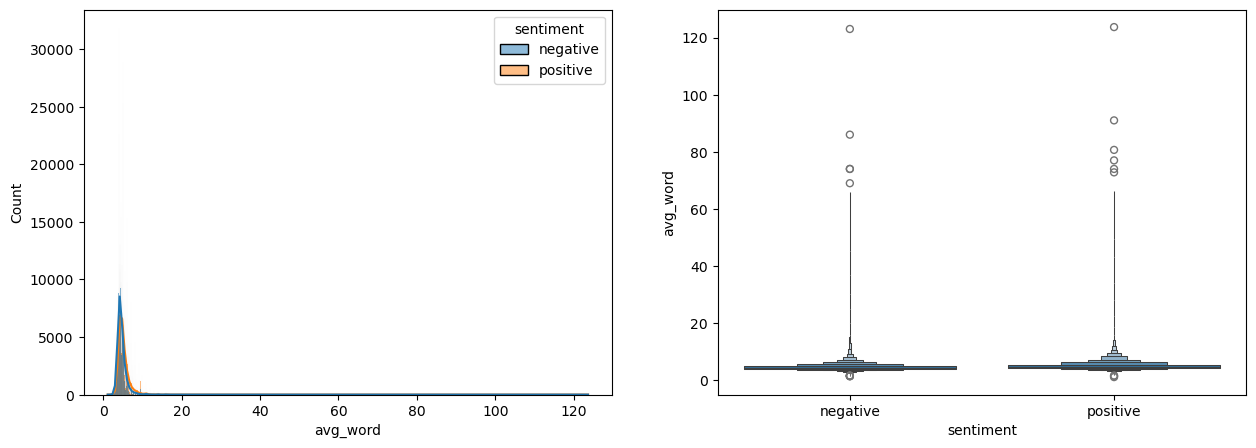

In [13]:
hf.box_hist_comparison(column="avg_word", target="sentiment", data=train_data)

Average word length is around 5, with some outliers where the word has 120 characters.

**Appearance of special characters**

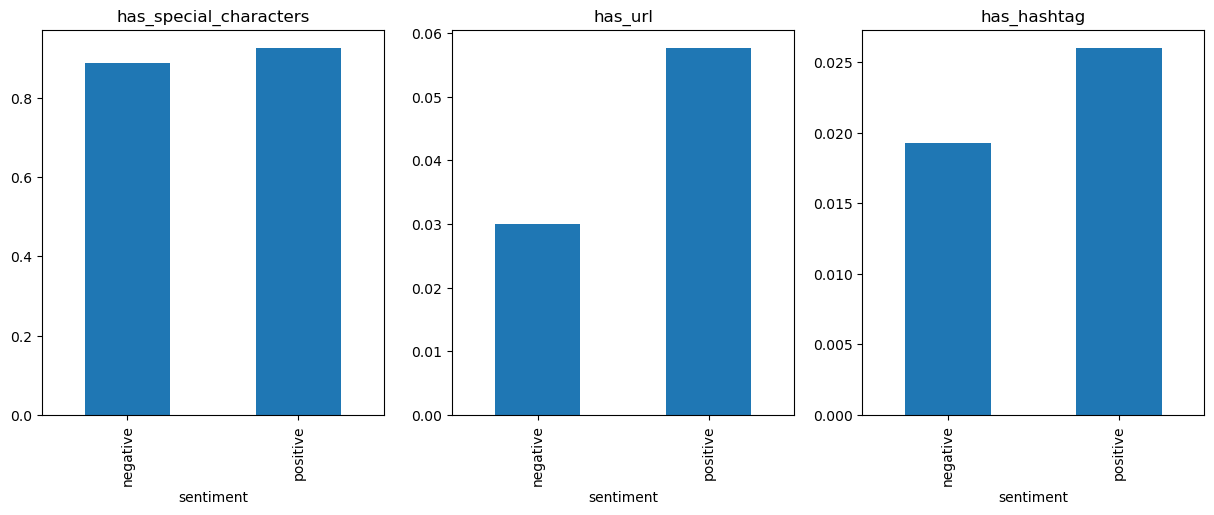

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(["has_special_characters", "has_url", "has_hashtag"]):
    ax[i].set_title(column)
    train_data.groupby("sentiment")[column].mean().plot(kind="bar", ax=ax[i])

When comparing presence of different special characters, we see that tweets that contain URLs are more likely to be positive.

**Let's compare numbers**

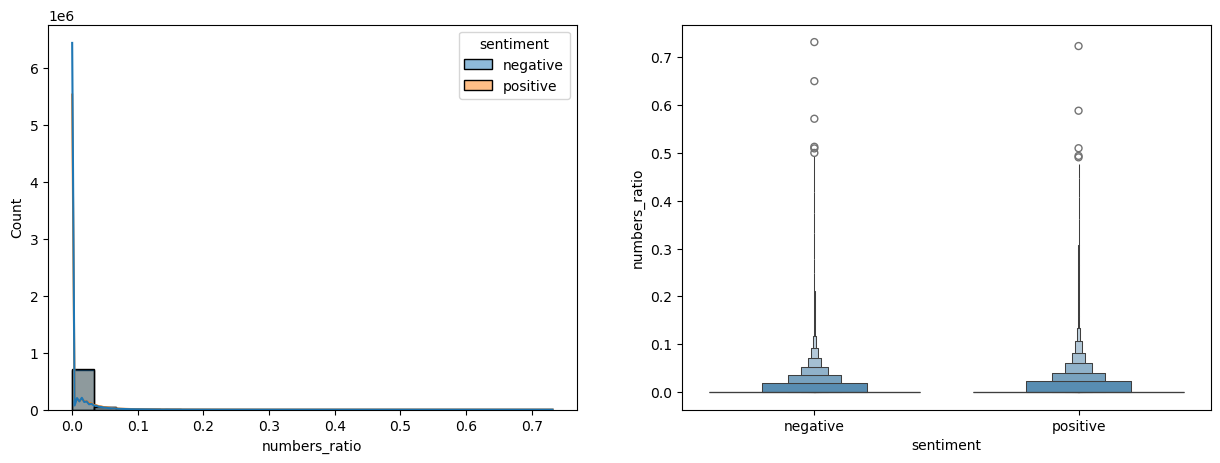

In [15]:
hf.box_hist_comparison(column="numbers_ratio", 
                       target="sentiment", data=train_data)

The ratio of numbers appears to be similar between two classes

**Number of words in a tweet**

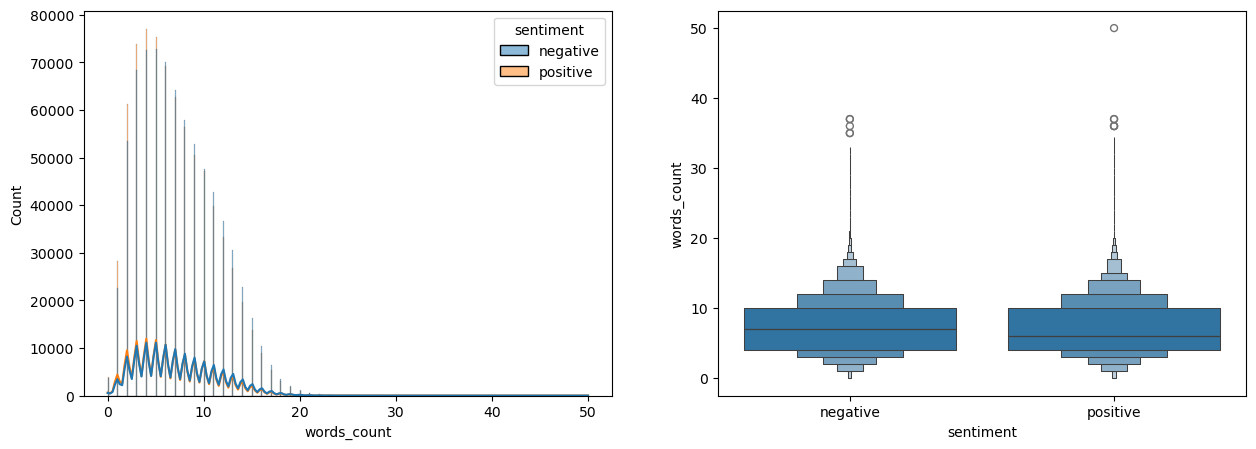

In [16]:
hf.box_hist_comparison(column="words_count", 
                       target="sentiment", data=train_data)

The number of words is also similar between two classes. Tweets usually hava less than 10 words.

**Now, let's plot the word clouds for both classes. This will help us to see most popular words for two sentiments**

Text(0.5, 1.0, 'Negative Sentiment Word Cloud')

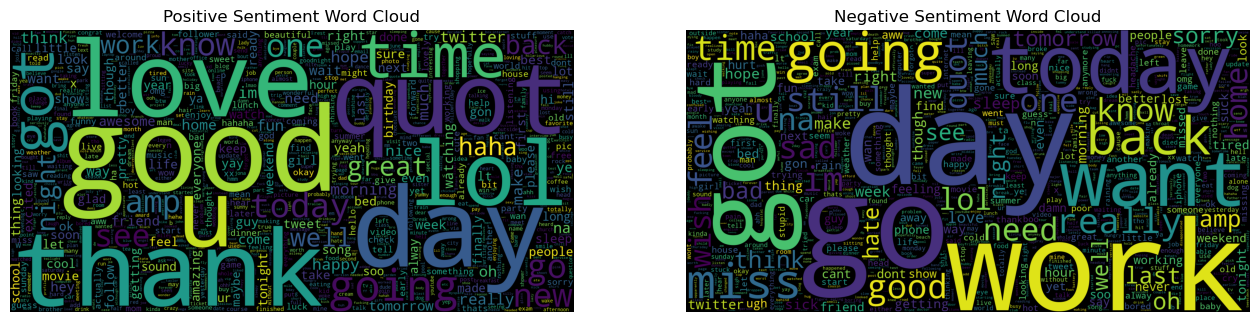

In [17]:
positive_words = train_data[train_data['sentiment'] == 'positive']["preprocessed_text"]
negative_words = train_data[train_data['sentiment'] == 'negative']["preprocessed_text"]

positive_cloud = WordCloud(max_words = 1000, width = 1600,
                          height = 800, collocations=False).generate(" ".join(positive_words))
negative_cloud = WordCloud(max_words = 1000, width = 1600, 
                        height = 800, collocations=False).generate(" ".join(negative_words))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1) 
plt.imshow(positive_cloud)
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')

plt.subplot(1, 2, 2) 
plt.imshow(negative_cloud)
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')

The word clouds indicate expected differences. Words like 'good', 'love', 'thank', 'happy' are more popular among positive tweets. Interestingly, 'work' word is very popular among negative tweets. There are some words that are popular in both sentiments: 'day', 'today', 'got'.

**Exclamations mark could also tell us something about sentiments. Let's compare them too.**

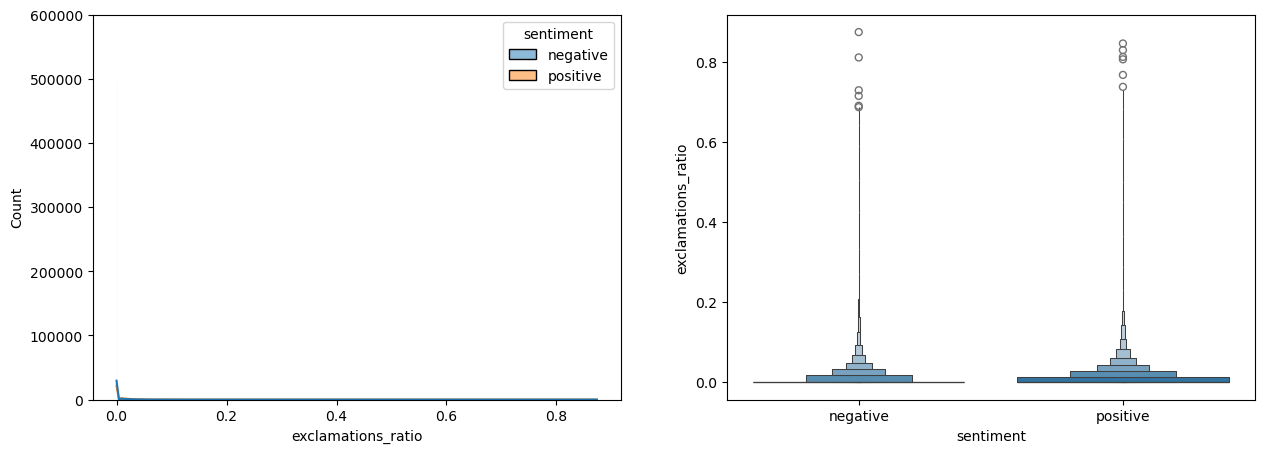

In [18]:
hf.box_hist_comparison(column="exclamations_ratio", target="sentiment", data=train_data)

The ratio is similar between both classes.

**Also, let's compare number of consecutive exclamations in a tweet**

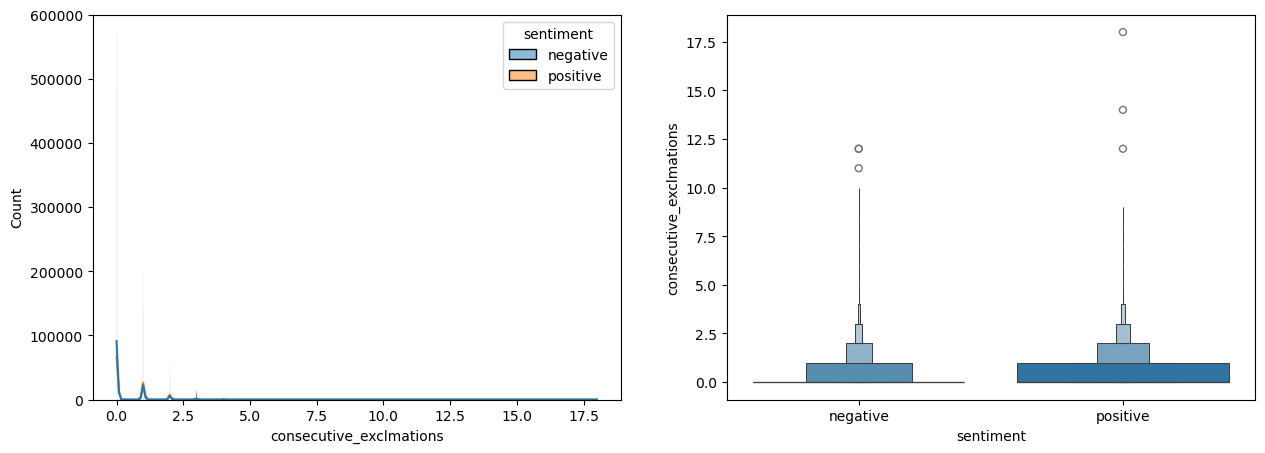

In [19]:
hf.box_hist_comparison(column="consecutive_exclmations", 
                       target="sentiment", data=train_data)

Also, the plots are similar between classes

## Conclusion: 

We have successfully conducted EDA on our tweets. We have discovered that the dataset is perfectly balanced with 800,000 of tweets per class. Different features, like the length of the text, average lenght of words, etc. are similar between both classes. Also the text was preprocessed for modeling by converting the text to lowercase, removing URLs, usernames, non-alphanumeric characters, stopwords, and lemmatizing words. 


### Load the data

In [20]:
train_data.to_csv("../data/train_data.csv", index=0)
test_data.to_csv("../data/test_data.csv", index=0)